In [ ]:
!pip3 install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import time, hashlib, json
import matplotlib.pyplot as plt

In [ ]:
# -------------------------------
# Blockchain Implementation
# -------------------------------

class Transaction:
    def __init__(self, device_id, model_update, timestamp=None, signature=None):
        self.device_id = device_id
        self.model_update = model_update
        self.timestamp = timestamp or time.time()
        self.signature = signature or self.sign_transaction()

    def sign_transaction(self):
        """Generate a cryptographic signature for the transaction"""
        tx_str = f"{self.device_id}{self.model_update}{self.timestamp}"
        return hashlib.sha256(tx_str.encode()).hexdigest()

    def to_dict(self):
        """Return transaction data as a dictionary"""
        return {
            "device_id": self.device_id,
            "model_update": self.model_update,
            "timestamp": self.timestamp,
            "signature": self.signature,
        }

In [ ]:
class Block:
    def __init__(self, index, transactions, previous_hash, timestamp=None, nonce=0):
        self.index = index
        self.transactions = transactions
        self.previous_hash = previous_hash
        self.timestamp = timestamp or time.time()
        self.nonce = nonce
        self.hash = self.compute_hash()

    def compute_hash(self):
        """Generate SHA-256 hash for the block"""
        block_content = {
            "index": self.index,
            "transactions": [tx.to_dict() for tx in self.transactions],
            "previous_hash": self.previous_hash,
            "timestamp": self.timestamp,
            "nonce": self.nonce,
        }
        block_string = json.dumps(block_content, sort_keys=True)
        return hashlib.sha256(block_string.encode()).hexdigest()

In [ ]:
class Blockchain:
    def __init__(self, difficulty=2):
        self.unconfirmed_transactions = []
        self.chain = []
        self.difficulty = difficulty
        self.create_genesis_block()

    def create_genesis_block(self):
        """Create the first block in the blockchain (Genesis Block)"""
        genesis_block = Block(0, [], "0", time.time())
        genesis_block.hash = genesis_block.compute_hash()
        self.chain.append(genesis_block)

    def last_block(self):
        """Retrieve the most recent block in the chain"""
        return self.chain[-1]

    def add_transaction(self, transaction):
        """Add a transaction to the pending transaction list"""
        if self.verify_transaction(transaction):
            self.unconfirmed_transactions.append(transaction)
            print(f"✅ Transaction Added: Device {transaction.device_id} at {time.ctime(transaction.timestamp)}")
            return True
        print(f"❌ Transaction Verification Failed for {transaction.device_id}")
        return False

    def verify_transaction(self, transaction):
        """Verify that the transaction signature is valid"""
        expected_signature = hashlib.sha256(
            f"{transaction.device_id}{transaction.model_update}{transaction.timestamp}".encode()
        ).hexdigest()
        return transaction.signature == expected_signature

    def proof_of_work(self, block):
        """Perform mining (Proof-of-Work) by finding a valid hash"""
        block.nonce = 0
        computed_hash = block.compute_hash()
        while not computed_hash.startswith('0' * self.difficulty):
            block.nonce += 1
            computed_hash = block.compute_hash()
        return computed_hash

    def add_block(self, block, proof):
        """Validate and add a new block to the blockchain"""
        if self.last_block().hash != block.previous_hash:
            return False
        if not proof.startswith('0' * self.difficulty) or proof != block.compute_hash():
            return False
        self.chain.append(block)
        print(f"🟢 Block {block.index} Mined: {block.hash}")
        return True

    def mine(self):
        """Mine a new block from pending transactions"""
        if not self.unconfirmed_transactions:
            print("⛔ No transactions to mine")
            return None
        new_block = Block(
            index=self.last_block().index + 1,
            transactions=self.unconfirmed_transactions,
            previous_hash=self.last_block().hash
        )
        proof = self.proof_of_work(new_block)
        self.add_block(new_block, proof)
        self.unconfirmed_transactions = []  # Clear transaction pool after mining
        return new_block


In [ ]:
# -------------------------------
# Deep Learning Model Definition
# -------------------------------

def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# -------------------------------
# Training and Blockchain Storage
# -------------------------------

def train_and_store(dataset_list, num_epochs=3, batch_size=32, save_path="models/"):
    blockchain = Blockchain(difficulty=2)
    os.makedirs(save_path, exist_ok=True)

    metrics = {"Device": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": [], "AUC": []}

    print("\n📊 Model Performance Metrics Summary:")
    print("=====================================")

    for device_id, dataset_path in enumerate(dataset_list, start=1):
        print(f"\n🔹 Training Model for Device {device_id} ({dataset_path})")

        df = pd.read_csv(dataset_path, low_memory=False)
        df_numeric = df.select_dtypes(include=[np.number])

        X = df_numeric.iloc[:, :-1].values.astype(np.float32)
        y = df_numeric.iloc[:, -1].values.astype(np.float32)
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-8)  # Normalize

        input_dim = X.shape[1]
        model = create_model(input_dim)
        model.fit(X, y, epochs=num_epochs, batch_size=batch_size, verbose=0)

        # Save Model
        model_filename = f"{save_path}/device_{device_id}_model.h5"
        model.save(model_filename)
        print(f"💾 Model Saved: {model_filename}")

        # Evaluate Model
        y_pred = (model.predict(X) > 0.5).astype(int)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, zero_division=1)
        recall = recall_score(y, y_pred, zero_division=1)
        f1 = f1_score(y, y_pred, zero_division=1)
        auc = roc_auc_score(y, y_pred)

        print(f"\nMetrics for Device {device_id}:")
        print("--------------------")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        print(f"AUC:      {auc:.4f}")
        print("--------------------")

        metrics["Device"].append(f"Device {device_id}")
        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)
        metrics["AUC"].append(auc)

        # Store on Blockchain
        weights = model.get_weights()
        transaction = Transaction(device_id=f"Device_{device_id}", model_update={"weights": [w.tolist() for w in weights]})
        blockchain.add_transaction(transaction)
        blockchain.mine()

     # Add final summary table
    print("\n📈 Final Performance Summary:")
    print("============================")
    df_metrics = pd.DataFrame(metrics)
    df_metrics = df_metrics.set_index('Device')
    print(df_metrics.round(4).to_string())

    # Plot Metrics
    plot_metrics(metrics)

def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    for metric in ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]:
        plt.plot(metrics["Device"], metrics[metric], marker='o', label=metric)

    plt.xlabel("Devices")
    plt.ylabel("Scores")
    plt.title("Model Performance Across IIoT Devices")
    plt.legend()
    plt.grid()
    plt.show()



📊 Model Performance Metrics Summary:

🔹 Training Model for Device 1 (datasets/ML-EdgeIIoT-dataset.csv)


💾 Model Saved: models//device_1_model.h5
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 4s 727us/step

Metrics for Device 1:
--------------------
Accuracy:  0.9083
Precision: 0.9065
Recall:    0.9942
F1-Score:  0.9483
AUC:      0.7154
--------------------
✅ Transaction Added: Device Device_1 at Sat Mar 15 00:44:45 2025
🟢 Block 1 Mined: c1beefe6180b651535dc5a6f294f9f4a18e95031b846431450d9d1159278ed4a

🔹 Training Model for Device 2 (datasets/wustl_iiot_2021.csv)


💾 Model Saved: models//device_2_model.h5
37327/37327 ━━━━━━━━━━━━━━━━━━━━ 22s 591us/step

Metrics for Device 2:
--------------------
Accuracy:  0.9996
Precision: 0.9983
Recall:    0.9959
F1-Score:  0.9971
AUC:      0.9979
--------------------
✅ Transaction Added: Device Device_2 at Sat Mar 15 00:47:43 2025
🟢 Block 2 Mined: cdecabd038b5d8aff7f0b0dfb66f161fcc67097c240b354c378638f50a19da15

🔹 Training Model for Device 3 (datasets/X-IIoTID dataset.csv)


💾 Model Saved: models//device_3_model.h5
25652/25652 ━━━━━━━━━━━━━━━━━━━━ 15s 590us/step

Metrics for Device 3:
--------------------
Accuracy:  0.9997
Precision: 0.9967
Recall:    1.0000
F1-Score:  0.9983
AUC:      0.9999
--------------------
✅ Transaction Added: Device Device_3 at Sat Mar 15 00:49:50 2025
🟢 Block 3 Mined: b801c07114e2d2aefc5d8f960dd1f6df6d1ea846247668c64d02323c9cad4448

🔹 Training Model for Device 4 (datasets/DNN-EdgeIIoT-dataset.csv)


💾 Model Saved: models//device_4_model.h5
69351/69351 ━━━━━━━━━━━━━━━━━━━━ 44s 635us/step

Metrics for Device 4:
--------------------
Accuracy:  0.9726
Precision: 0.9984
Recall:    0.9007
F1-Score:  0.9470
AUC:      0.9501
--------------------
✅ Transaction Added: Device Device_4 at Sat Mar 15 00:55:39 2025
🟢 Block 4 Mined: a844ba96d459f00ff35f824a37ceafe2bdc5007d64eaabecae8793e7c5a1c2d8

📈 Final Performance Summary:
          Accuracy  Precision  Recall  F1-Score     AUC
Device                                                 
Device 1    0.9083     0.9065  0.9942    0.9483  0.7154
Device 2    0.9996     0.9983  0.9959    0.9971  0.9979
Device 3    0.9997     0.9967  1.0000    0.9983  0.9999
Device 4    0.9726     0.9984  0.9007    0.9470  0.9501


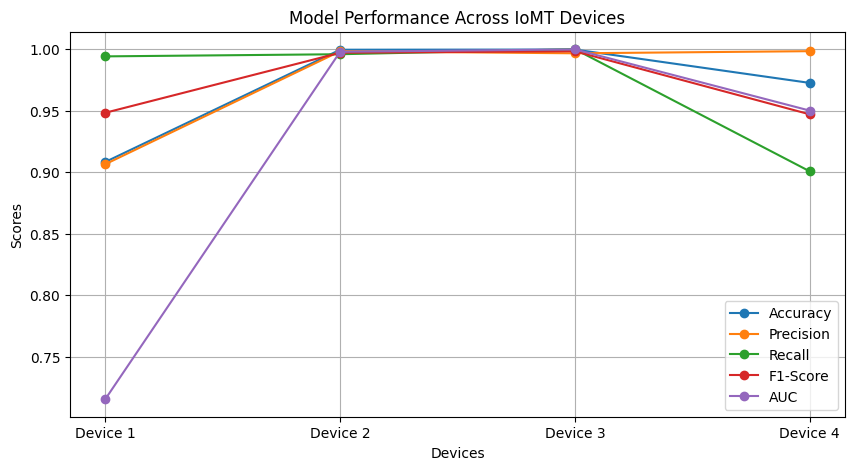

In [ ]:
# -------------------------------
# Run the Training Process
# -------------------------------

if __name__ == "__main__":
    dataset_folder = "datasets/"
    dataset_list = [os.path.join(dataset_folder, f) for f in os.listdir(dataset_folder) if f.endswith(".csv")]

    if len(dataset_list) < 1:
        print("⛔ Error: No datasets found in 'datasets/' folder!")
    else:
        train_and_store(dataset_list)